In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

import clip
import imageio
import umap
from scipy.spatial import distance

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

device = "cuda"
#
# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [2]:
# Load 73k NSD images
data_path = "/weka/proj-medarc/shared/mindeyev2_dataset"
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu")
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


In [3]:
shared1000 = np.load("/weka/proj-medarc/shared/mindeyev2_dataset/shared1000.npy")
len(shared1000)

73000

In [4]:
images = images[shared1000]
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [5]:
folder_path = "Cropped"
target_images = None

# Loop through the folder and load each image
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(folder_path, filename)
        image = imageio.imread(img_path)
        image = transforms.ToTensor()(image)[None]
        if target_images is None:
            target_images = image
        else:
            target_images = torch.vstack((target_images, image))

print("target_images", target_images.shape)

target_images torch.Size([3, 3, 448, 448])


/tmp/ipykernel_1049268/2946129907.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


In [6]:
# for ii,im in enumerate(target_images):
#     PIL_image = transforms.ToPILImage()(im)
#     PIL_image.save(f"stimuli/target{ii}.jpg")

In [7]:
# folder_path = "Extras"
# extra_images = None

# # Function to center crop the image to a square
# def center_crop(image):
#     _, _, h, w = image.shape
#     crop_size = min(h, w)
#     transform = transforms.CenterCrop(crop_size)
#     return transform(image)

# def resize(image):
#     return transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR)(image)

# # Loop through the folder and load each image
# for filename in os.listdir(folder_path):
#     if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
#         img_path = os.path.join(folder_path, filename)
#         image = imageio.imread(img_path)
#         if image.ndim == 3 and image.shape[2] == 4:  # Check if image has alpha channel
#             image = image[:, :, :3]  # Discard alpha channel
#         image = transforms.ToTensor()(image)[None]
#         image = center_crop(image)
#         image = resize(image)
#         if extra_images is None:
#             extra_images = image
#         else:
#             extra_images = torch.vstack((extra_images, image))

# print("extra_images", extra_images.shape)

In [8]:
# for ii,im in enumerate(extra_images):
#     PIL_image = transforms.ToPILImage()(im)
#     PIL_image.save(f"stimuli/extra{ii}.jpg")

In [10]:
folder_path = "Album"
album_images = None

# Function to center crop the image to a square
def center_crop(image):
    _, _, h, w = image.shape
    crop_size = min(h, w)
    transform = transforms.CenterCrop(crop_size)
    return transform(image)

def resize(image):
    return transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR)(image)

# Loop through the folder and load each image
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        image = imageio.imread(img_path)
        if image.ndim == 3 and image.shape[2] == 4:  # Check if image has alpha channel
            image = image[:, :, :3]  # Discard alpha channel
        image = transforms.ToTensor()(image)[None]
        image = center_crop(image)
        image = resize(image)
        if album_images is None:
            album_images = image
        else:
            album_images = torch.vstack((album_images, image))

print("album_images", album_images.shape)

/tmp/ipykernel_1352236/3395652792.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


album_images torch.Size([17, 3, 425, 425])


In [11]:
for ii,im in enumerate(album_images):
    PIL_image = transforms.ToPILImage()(im)
    PIL_image.save(f"stimuli/album{ii}.jpg")

In [5]:
# for im in album_images:
#     display(utils.torch_to_Image(im))

## CLIP UMAP

In [9]:
## CLIP VIT-L 14
clip_model, preprocess = clip.load("ViT-L/14", device=device)
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])
def clip_img_embedder(image):
    preproc_img = preprocess(image)
    return clip_model.encode_image(preproc_img)
clip_seq_dim = 1
clip_emb_dim = 768

In [277]:
all_clipimgs = None
minibatch_size = 64
with torch.no_grad():
    for batch in tqdm(range(0,len(images),minibatch_size)):
        cur_images = images[batch:batch+minibatch_size]
        cur_images_clip = clip_img_embedder(cur_images.to(device)).to("cpu")
        if all_clipimgs is None:
            all_clipimgs = cur_images_clip
        else:
            all_clipimgs = torch.vstack((all_clipimgs, cur_images_clip))

print("all_clipimgs", all_clipimgs.shape)

100%|███████████████████████████████████████| 1125/1125 [01:05<00:00, 17.23it/s]

all_clipimgs torch.Size([72000, 768])


In [278]:
with torch.no_grad():
    target_images_clip = clip_img_embedder(target_images.to(device)).to("cpu")
    # extra_images_clip = clip_img_embedder(extra_images.to(device)).to("cpu")
# all_clipimgs = torch.vstack((extra_images_clip, all_clipimgs))
all_clipimgs = torch.vstack((target_images_clip, all_clipimgs))
print("all_clipimgs", all_clipimgs.shape)

all_clipimgs torch.Size([72003, 768])


/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [158]:
# torch.save(all_clipimgs,"all_clipimgs.pt")
# all_clipimgs = torch.load("all_clipimgs.pt")
# print("all_clipimgs", all_clipimgs.shape)

In [279]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(all_clipimgs.detach().numpy())

/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


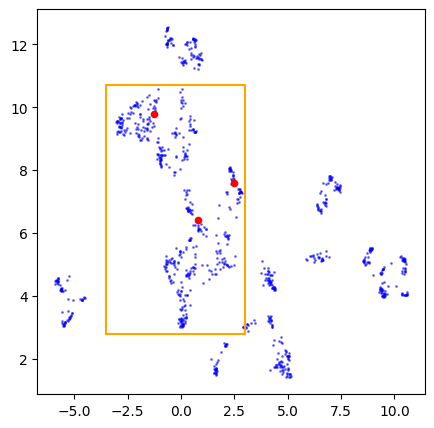

In [271]:
plt.figure(figsize=(5, 5))

# plt.scatter(embedding[3:53, 0], embedding[3:53, 1], c='black', label='Extras', alpha=.5, s=10)

plt.scatter(embedding[3:, 0], embedding[3:, 1], c='blue', label='Images', alpha=.5, s=1)

plt.scatter(embedding[:3, 0], embedding[:3, 1], c='red', label='Target', s=20)

plt.plot([-3.5, 3, 3, -3.5, -3.5], [2.8, 2.8, 10.7, 10.7, 2.8], c='orange', ls='-')

# plt.xlim(6,12)
# plt.ylim(-2,5)

plt.show()

In [272]:
a = np.where((embedding[:, 0] >= -3.5) & (embedding[:, 0] <= 3))[0]
b = np.where((embedding[:, 1] >= 2.8) & (embedding[:, 1] <= 10.7))[0]
intersection = np.intersect1d(a, b)
print(len(intersection))
unique_intersections = intersection[3:]-3
print(len(unique_intersections))

486
483


In [216]:
# Extras (1 per session) | shared1000 (repeated twice) | targets (4 per session) | more COCO
(50*3) + (483*2) + (3*12) + 381

1535

In [273]:
for idx in tqdm(unique_intersections):
    im = nsd_stimuli[idx]
    PIL_image = transforms.ToPILImage()(im)
    PIL_image.save(f"stimuli/coco_shared_{idx}.jpg")

100%|████████████████████████████████████████| 483/483 [00:04<00:00, 104.31it/s]


3.4092517375946043 3.8092517375946047 -7.305498313903809 -6.905498313903808
5.579965591430664 6.079965591430664 0.42804259061813354 0.9280425906181335
8.281805038452148 9.281805038452148 -3.6357309818267822 -2.6357309818267822


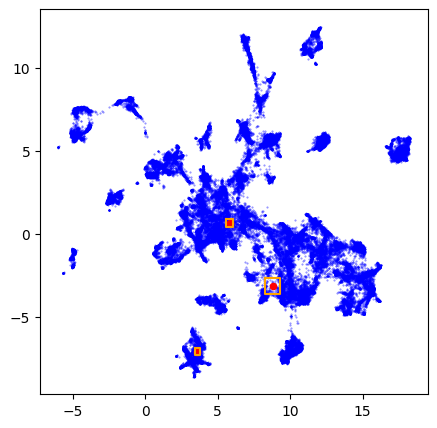

In [282]:
plt.figure(figsize=(5, 5))
plt.scatter(embedding[3:, 0], embedding[3:, 1], c='blue', label='Images', alpha=.5, s=.2)
plt.scatter(embedding[:3, 0], embedding[:3, 1], c='red', label='Images', s=20)

# bottom
e = embedding[0]
d = .2
x1 = e[0]-d
x2 = e[0]+d
y1 = e[1]-d
y2 = e[1]+d
print(x1,x2,y1,y2)
plt.plot([x1, x2, x2, x1, x1], [y2, y2, y1, y1, y2], c='orange', ls='-')

# top
# plt.plot([5, 6, 6, 5, 5], [1, 1, 0, 0, 1], c='orange', ls='-')
e = embedding[1]
d = .25
x1 = e[0]-d
x2 = e[0]+d
y1 = e[1]-d
y2 = e[1]+d
print(x1,x2,y1,y2)
plt.plot([x1, x2, x2, x1, x1], [y2, y2, y1, y1, y2], c='orange', ls='-')

# right
e = embedding[2]
x1 = e[0]-.5
x2 = e[0]+.5
y1 = e[1]-.5
y2 = e[1]+.5
print(x1,x2,y1,y2)
plt.plot([x1, x2, x2, x1, x1], [y2, y2, y1, y1, y2], c='orange', ls='-')

plt.show()

In [284]:
total = 0 

a = np.where((embedding[:,0] >= 3.40925) & (embedding[:,0] <= 3.8092))[0]
b = np.where((embedding[:,1] >= -7.3054) & (embedding[:,1] <= -6.905))[0]
intersection = np.intersect1d(a, b)
print(len(intersection))
total += len(intersection)-1
unique_intersections = intersection[1:]-3

a = np.where((embedding[:,0] >= 5.579965) & (embedding[:,0] <= 6.07996))[0]
b = np.where((embedding[:,1] >= .428042) & (embedding[:,1] <= .92804))[0]
intersection = np.intersect1d(a, b)
print(len(intersection))
total += len(intersection)-1
unique_intersections = np.append(unique_intersections, intersection[1:]-3)

a = np.where((embedding[:,0] >= 8.28180) & (embedding[:,0] <= 9.2818))[0]
b = np.where((embedding[:,1] >= -3.6357) & (embedding[:,1] <= -2.6357))[0]
intersection = np.intersect1d(a, b)
print(len(intersection))
total += len(intersection)-1
unique_intersections = np.append(unique_intersections, intersection[1:]-3)

print("total", total)
print("unique_intersections", unique_intersections.shape)

124
124
138
total 383
unique_intersections (383,)


In [281]:
f = h5py.File('/weka/proj-medarc/shared/mindeyev2_dataset/nsd_stimuli.hdf5', 'r')
nsd_stimuli = f['imgBrick']
nsd_stimuli = nsd_stimuli[~shared1000]
nsd_stimuli.shape

(72000, 425, 425, 3)

In [285]:
for idx in tqdm(unique_intersections):
    im = nsd_stimuli[idx]
    PIL_image = transforms.ToPILImage()(im)
    PIL_image.save(f"stimuli/coco_nonshared_{idx}.jpg")

# REMOVE 
# coco_nonshared_12610.jpg
# coco_nonshared_9298__magazineembedded_furniture_leg.jpg
# coco_nonshared_34275__antiobama_protest_signs.jpg
# coco_nonshared_54382__dead_animals_dissection.jpg

100%|████████████████████████████████████████| 383/383 [00:02<00:00, 146.93it/s]


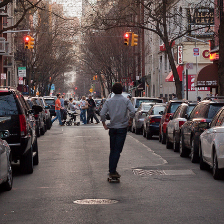

In [210]:
utils.torch_to_Image(images[intersection[1]-3])

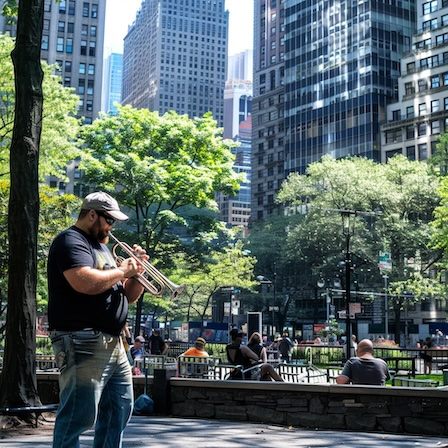

In [211]:
utils.torch_to_Image(target_images[1])

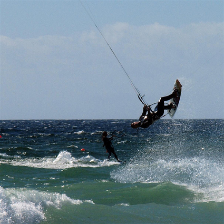

In [60]:
utils.torch_to_Image(images[60734])

In [57]:
from scipy.spatial import KDTree

tree = KDTree(embedding[3:])
sample = embedding[3]
distances, indices = tree.query(sample, k=100)

print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [    0 24287 43342 60734 36931 69868 59297 23110  2594  6849 29269 43469
 12570 42574 62834 35508 17035 48494 36655 59976 42673  4707 47015 45097
 57583 51769 71367 45784 62325  7858 46804 68626 61882 36321 10001  6384
 16094 10261 61202 39556 36544 55595 13074 56247 61785 39511 50729 48946
 68485 21067 56724  5113 30691 60739 69646 64270 64396 28877 32337 14710
 18631  3431 36224 15587  3106 49020 28908  2666 23295  1670 40028 46742
 14907 29705 45139 39768 38046 19252  4936 42370 19136  1025 35275  6464
  2567 16425   564 33944 28418 71705 20382  3411 23251 42659 27520 23533
  6067 12812  5769 35388]
Distances to nearest neighbors: [0.         0.00395261 0.0070228  0.00739693 0.01144818 0.01244082
 0.01263475 0.01308659 0.01325747 0.01336386 0.01423895 0.01539964
 0.01638659 0.01652522 0.01715768 0.01739518 0.01866934 0.01913158
 0.01913804 0.02027416 0.02108486 0.02200749 0.02266732 0.02298814
 0.0236624  0.02400968 0.02552528 0.02687554 0.02869299 0.03

# OPENCLIP

In [49]:
# OPENCLIP VIT bigG 14
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [53]:
import umap
from scipy.spatial import distance

all_openclipimgs = None
minibatch_size = 256
with torch.no_grad():
    for batch in tqdm(range(0,len(images),minibatch_size)):
        cur_images = images[batch:batch+minibatch_size]
        cur_images_clip = clip_img_embedder(cur_images.to(device)).to("cpu")
        if all_openclipimgs is None:
            all_openclipimgs = cur_images_clip
        else:
            all_openclipimgs = torch.vstack((all_openclipimgs, cur_images_clip))

print("all_openclipimgs", all_openclipimgs.shape)

100%|█████████████████████████████████████████| 286/286 [21:18<00:00,  4.47s/it]

all_clipimgs torch.Size([73000, 256, 1664])


In [54]:
with torch.no_grad():
    target_images_clip = clip_img_embedder(target_images.to(device)).to("cpu")
all_openclipimgs = torch.vstack((target_images_clip, all_openclipimgs))
print("all_openclipimgs", all_openclipimgs.shape)

all_clipimgs torch.Size([73003, 256, 1664])


In [6]:
# torch.save(all_openclipimgs,"all_openclipimgs.pt")
all_openclipimgs = torch.load("all_openclipimgs.pt")
print(all_openclipimgs.shape)

torch.Size([73003, 256, 1664])


In [ ]:
reducer = umap.UMAP(random_state=0)
open_embedding = reducer.fit_transform(all_openclipimgs.flatten(1).detach().numpy())

/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(open_embedding[3:, 0], open_embedding[3:, 1], c='blue', label='Images', alpha=.5, s=.2)
plt.scatter(open_embedding[:3, 0], open_embedding[:3, 1], c='red', label='Images', s=20)
# plt.savefig(f'{model_name}_umap_retrieval.png')
plt.show()